# Resturant Food Safety Inspection Prediction Using Natual Language Processing

references:
https://dev.socrata.com/foundry/data.cityofchicago.org/4ijn-s7e5

## Summary
1. [Objective](#objective)
2. [Understanding the Data](#data)\
    2.1 [Dataset Definitions](#dataset)\
    2.2 [Observations](#observations)\
    2.3 [Feature Engineering](#engineering)
4. [Model Building](#model)\
    4.1 [Model Overview](#modeloverview)
5. [Interpretation of Results](#interpretation)
6. [References](#references)



# 1. Objective
<a id='objective'></a>

The goal of this notebook is to build a multinomial classification model to predict the outcome of the food safety inspection reports based on the inspectors' comments. I will use from statistical analysis and natural language processing to accomplish this. I will also present the results of the classification model and suggest ways that it could be improved through further analysis.

Data provided by the City of Chicago via https://data.cityofchicago.org/ https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 as of early 2020

In [797]:
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import itertools
import os
import random


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import sys

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.mode.chained_assignment = None  # default='warn'


<a id='data'> </a>
# 2. Understanding the Data


<a id='dataset'> </a>
## 2.1 Preliminary Data Cleaning

In [798]:
#load the data
#df = pd.read_csv('../Food_Inspections.csv') #dataframe for modeling
#df_clean = df.copy() #cleaned dataframe for miscellaneous
#df_viz = df.copy() #dataframe for data viz exports for tableau


In [799]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
MyAppToken = 'KoNWmjvpkvV18BmVoGFCU1oCw'

client = Socrata("data.cityofchicago.org",
                  MyAppToken)
#                  userame="user@example.com",
 #                 password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("4ijn-s7e5", limit=250000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [800]:
results_df.shape

(212022, 22)

In [801]:
results_df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', ':@computed_region_awaf_s7ux',
       ':@computed_region_6mkv_f3dw', ':@computed_region_vrxf_vc4k',
       ':@computed_region_bdys_3d7i', ':@computed_region_43wa_7qmu'],
      dtype='object')

In [802]:
#drop extra columns from import
df = results_df.drop([':@computed_region_awaf_s7ux',
                 ':@computed_region_6mkv_f3dw',
                 ':@computed_region_vrxf_vc4k',
                 ':@computed_region_bdys_3d7i',
                 ':@computed_region_43wa_7qmu'], axis=1)

In [803]:
df.dtypes

inspection_id      object
dba_name           object
aka_name           object
license_           object
facility_type      object
risk               object
address            object
city               object
state              object
zip                object
inspection_date    object
inspection_type    object
results            object
violations         object
latitude           object
longitude          object
location           object
dtype: object

In [804]:
print(df.shape)
df.info()

(212022, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212022 entries, 0 to 212021
Data columns (total 17 columns):
inspection_id      212022 non-null object
dba_name           212022 non-null object
aka_name           209540 non-null object
license_           212005 non-null object
facility_type      207142 non-null object
risk               211950 non-null object
address            212022 non-null object
city               211868 non-null object
state              211974 non-null object
zip                211970 non-null object
inspection_date    212022 non-null object
inspection_type    212021 non-null object
results            212022 non-null object
violations         155625 non-null object
latitude           504 non-null object
longitude          504 non-null object
location           504 non-null object
dtypes: object(17)
memory usage: 27.5+ MB


In [805]:
df.isna().sum()

inspection_id           0
dba_name                0
aka_name             2482
license_               17
facility_type        4880
risk                   72
address                 0
city                  154
state                  48
zip                    52
inspection_date         0
inspection_type         1
results                 0
violations          56397
latitude           211518
longitude          211518
location           211518
dtype: int64

It appears that we have some incorrect data types and also some missing data. I'll inspect the data column by column

**inspection_id**

In [806]:
df['inspection_id'].isna().sum()

0

In [807]:
df['inspection_id'].sample(n=5)

149661    1335297
154312    1146292
93990     1591477
43408     2159814
56912     2072059
Name: inspection_id, dtype: object

**dba_name**

In [808]:
df['dba_name'].isna().sum()

0

In [809]:
df['dba_name'].sample(n=5)

63163                EL MILAGRO
53381     SHARKS FISH & CHICKEN
42745          TABAQ RESTAURANT
20570            FT WICKER PARK
108400         MCDONALD'S #4305
Name: dba_name, dtype: object

**aka_name**

In [810]:
df['aka_name'].isna().sum()

2482

In [811]:
#sample of the missing aka_name values
df[df['aka_name'].isna()][['inspection_id','dba_name','aka_name']]

,inspection_id,dba_name,aka_name
26,2453694,CENTERS FOR NEW HORIZONS,NaN
101,2453552,CLAMP DOWN BURGERS,NaN
272,2453268,CENTERS FOR NEW HORIZONS,NaN
747,2401721,BABAS STEAK AND LEMONADE,NaN
899,2401643,HEALTH FOOD & GROCERIES,NaN
...,...,...,...
211942,68254,"Eastside Soccer Dome, Inc.",NaN
211956,78239,Yahs Cuisine,NaN
211962,158243,DUNKIN DONUTS,NaN
211992,78240,OBAMA FOOD MART,NaN


In [812]:
#fill NaN values with dba_name value
df['aka_name'] = df['aka_name'].fillna(df['dba_name'])

**license_**

In [813]:
df['license_'].isna().sum()

17

In [814]:
#Mostly churches...
df[df['license_'].isna()]['dba_name']

23493              ST. DEMETRIOS GREEK ORTHODOX CHURCH
39992              ST. DEMETRIOS GREEK ORTHODOX CHURCH
57005              ST. DEMETRIOS GREEK ORTHODOX CHURCH
82502              ST. DEMETRIOS GREEK ORTHODOX CHURCH
102392             ST. DEMETRIOS GREEK ORTHODOX CHURCH
127817             ST. DEMETRIOS GREEK ORTHODOX CHURCH
130269                                 ARGENTINA FOODS
145120             ST. DEMETRIOS GREEK ORTHODOX CHURCH
164738             ST. DEMETRIOS GREEK ORTHODOX CHURCH
168130                        OLD ST. PATRICK'S CHURCH
171469                 GOD'S BATTLE AXE PRAYER ACADEMY
171721                 GOD'S BATTLE AXE PRAYER ACADEMY
173217                 GOD'S BATTLE AXE PRAYER ACADEMY
182446             ST. DEMETRIOS GREEK ORTHODOX CHURCH
193602    AVALON COMMUNITY CHURCH/FREEDOM HOME ACADEMY
201799                             ST DEMETRIOS CHURCH
204392                        OLD ST. PATRICK'S CHURCH
Name: dba_name, dtype: object

In [815]:
#fill with "Not Disclosed"
df['license_'] = df['license_'].fillna('Not Disclosed')

**facility_type**

In [816]:
df['facility_type'].isna().sum()

4880

In [817]:
df[df['facility_type'].isna()]['dba_name'].value_counts().head(20)

SUBWAY                          34
DUNKIN DONUTS                   20
7-ELEVEN                        18
WHITE HEN PANTRY                18
HAROLD'S CHICKEN SHACK          15
TOKYO LUNCH BOXES & CATERING    13
KENTUCKY FRIED CHICKEN          12
MIDWEST BUDDHIST TEMPLE         11
MCDONALD'S                      10
MCDONALDS                        8
HEAVEN'S LEARNING GARDEN         7
SCHLENKO INC.                    7
GOLD COAST DOGS                  6
COLD STONE CREAMERY              6
THUNDERBIRD CATERING             6
CALIFORNIA FOODS                 5
MAN-O-SALWA                      5
BELEN                            5
DEOLA'S                          5
QUIZNOS                          5
Name: dba_name, dtype: int64

In [818]:
df[df['facility_type'].isna()]['dba_name'].value_counts().describe()

count    4108.000000
mean        1.187926
std         0.949276
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        34.000000
Name: dba_name, dtype: float64

In [819]:
df['facility_type'].value_counts().head(15)

Restaurant                         141072
Grocery Store                       27738
School                              13076
Children's Services Facility         3574
Bakery                               3095
Daycare (2 - 6 Years)                2793
Daycare Above and Under 2 Years      2580
Long Term Care                       1426
Catering                             1278
Liquor                                931
Mobile Food Dispenser                 883
Daycare Combo 1586                    741
Mobile Food Preparer                  673
Golden Diner                          599
Hospital                              592
Name: facility_type, dtype: int64

It's not clear why so many of these facility types are missing. Some of the businesses are obvious (7-Eleven, Quiznos, for instance) but many aren't... For now, I'll fill the NA values with not disclosed


In [820]:
df['facility_type'] = df['facility_type'].fillna('Not Disclosed')

**risk**

In [821]:
df['risk'].value_counts()

Risk 1 (High)      151563
Risk 2 (Medium)     41384
Risk 3 (Low)        18972
All                    31
Name: risk, dtype: int64

In [822]:
df['risk'].isna().sum()

72

In [823]:
df[df['risk'].isna()].sample(n=5, random_state=512)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
65053,2009375,"CHICAGO BEST DELI GROCERY,INC","CHICAGO BEST DELI GROCERY,INC",2512074,Not Disclosed,NaN,156-158 W 95TH ST,CHICAGO,IL,60628,2017-03-28T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN
181081,537572,unknown,unknown,0,Not Disclosed,NaN,10222 S wentworth AVE,CHICAGO,IL,60628,2011-09-07T00:00:00.000,Complaint-Fire,Business Not Located,NaN,NaN,NaN,NaN
34914,2229372,RICE THAI CAFE,RICE THAI CAFE,2589016,Not Disclosed,NaN,211`7 W FARRAGUT AVE,CHICAGO,IL,60625,2018-10-04T00:00:00.000,License,Business Not Located,NaN,NaN,NaN,NaN
196571,428391,BEST SUBS,BEST SUBS,0,Not Disclosed,NaN,2653 N WASTENAW AVE BLDG,CHICAGO,IL,60647,2010-10-29T00:00:00.000,Complaint,Business Not Located,NaN,NaN,NaN,NaN
25354,2286042,REIS AND IRVYS,REIS AND IRVYS,2659028,Not Disclosed,NaN,1801 W JACKSON BLVD,CHICAGO,IL,60612,2019-04-30T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN


Notice that many of the missing risk values are records that were also missing other attributes...


In [824]:
#I'll fill missing risk values with not disclosed
df['risk'] = df['risk'].fillna('Not Disclosed')

**address**

In [825]:
df['address'].isna().sum()

0

In [826]:
df['address'].value_counts().head(10)

11601 W TOUHY AVE             2674
5700 S CICERO AVE              583
500 W MADISON ST               462
2300 S THROOP ST               405
324 N LEAVITT ST               391
131 N CLINTON ST               353
100 W RANDOLPH ST              331
222 W MERCHANDISE MART PLZ     279
600 E GRAND AVE                276
7601 S CICERO AVE              267
Name: address, dtype: int64

Some of these make sense:

* 5700 S CICERO AVE = Chicago Midway
* 500 W MADISON ST = Accenture Tower


**city**

In [827]:
df['city'].isna().sum()

154

In [831]:
df['city'].sample(n=5)

22590     CHICAGO
105541    CHICAGO
166608    CHICAGO
96379     CHICAGO
201767    CHICAGO
Name: city, dtype: object

In [832]:
df['city'] = df['city'].fillna('Not Disclosed')
df['city'] = df['city'].str.upper()

In [838]:
df['city'].value_counts().head(30)

CHICAGO                 211675
NOT DISCLOSED              154
SCHAUMBURG                  27
MAYWOOD                     16
ELK GROVE VILLAGE           13
EVANSTON                    11
CICERO                       9
INACTIVE                     8
SKOKIE                       8
NILES NILES                  7
ELMHURST                     7
CALUMET CITY                 6
OAK PARK                     5
WORTH                        5
BRIDGEVIEW                   4
ALSIP                        4
CHARLES A HAYES              4
SUMMIT                       4
ROSEMONT                     3
EAST HAZEL CREST             3
SCHILLER PARK                3
PLAINFIELD                   3
BLUE ISLAND                  2
NAPERVILLE                   2
BERWYN                       2
STREAMWOOD                   2
HIGHLAND PARK                2
BANNOCKBURNDEERFIELD         2
CHICAGO HEIGHTS              2
DES PLAINES                  1
Name: city, dtype: int64

In [837]:
df['city'] = df['city'].replace('chicago','CHICAGO')
df['city'] = df['city'].replace('Chicago','CHICAGO')
df['city'] = df['city'].replace('CCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGOCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGOHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGO.','CHICAGO')
df['city'] = df['city'].replace('312CHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHicago','CHICAGO')
df['city'] = df['city'].replace('CHICAGOI','CHICAGO')
df['city'] = df['city'].replace('CHCICAGO','CHICAGO')
#df['city'] = df['city'].replace('','CHICAGO')


**state**

In [839]:
df['state'].isna().sum()

48

In [840]:
df[df['state'].isna()][['dba_name','city','state']].head(10)

,dba_name,city,state
5637,CRATER FOOD & LIQUOR,CHICAGO,NaN
6182,YOLK - LINCOLN PARK,CHICAGO,NaN
6200,Starbucks Coffee#51211,NOT DISCLOSED,NaN
6231,CRATER FOOD & LIQUOR,CHICAGO,NaN
6691,STAX CAFE,CHICAGO,NaN
7083,WINGSTOP,CHICAGO,NaN
19165,"AMY BECK CAKE DESIGN, LLC",NOT DISCLOSED,NaN
23182,STAX CAFE,CHICAGO,NaN
23603,CITY HALL. LLC,CHICAGO,NaN
23605,CITY HALL. LLC,CHICAGO,NaN


It appears there is a data input problem. For now, I'll manually fill missing states


In [841]:
df.loc[(df.city=='CHICAGO')&(df.state.isna()),'state'] = 'IL'

In [842]:
df['state'] = df['state'].fillna('Not Disclosed')

In [843]:
df['state'].value_counts()

IL               211999
Not Disclosed        20
IN                    1
NY                    1
WI                    1
Name: state, dtype: int64

Not sure why there are other states in this dataset. For now, I'll drop other states.

In [844]:
index_list = df[df.state != 'IL'].index.to_list()

df = df.drop(index_list)

**zip**

In [845]:
df['zip'].isna().sum()

52

There are only 52 observations with missing zip values so I'll drop these values


In [846]:
df = df.dropna(subset=['zip'])

**inspection_date**

In [847]:
df['inspection_date'].isna().sum()

0

In [848]:
print(df['inspection_date'][5])
type(df['inspection_date'].iloc[5])

2020-10-23T00:00:00.000


str

I'll need to conver the inspection date column to datetime

In [849]:
#Convert inspection_date column
df['inspection_date_new'] = df['inspection_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))


In [850]:
df.iloc[0]['inspection_date_new'].strftime(format='%x')

'10/26/20'

In [851]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])


2020-10-23 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

In [852]:
df['inspection_date_new'] = df['inspection_date_new'].apply(lambda x: x.strftime(format='%x'))

In [853]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])

10/23/20


str

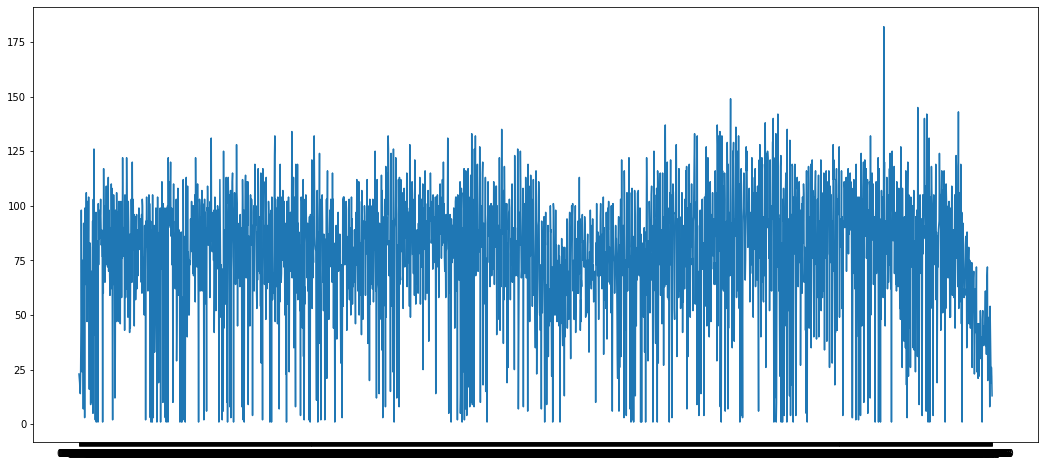

In [854]:
import matplotlib.pylab as plt
from collections import Counter

# Tally occurrences of words in a list
cnt = Counter()
for day in df['inspection_date_new']:
    cnt[day] += 1


lists = sorted(cnt.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(18,8))
plt.plot(x, y)

plt.show()


**inspection_type**


In [855]:
df['inspection_type'].isna().sum()


1

In [856]:
df = df.dropna(subset=['inspection_type'])


In [857]:
df['inspection_type'].value_counts().head(15)


Canvass                                   112771
License                                    27804
Canvass Re-Inspection                      22533
Complaint                                  19616
License Re-Inspection                       9471
Complaint Re-Inspection                     8096
Short Form Complaint                        7135
Suspected Food Poisoning                     874
Consultation                                 672
License-Task Force                           604
Tag Removal                                  603
Recent Inspection                            357
Out of Business                              284
Task Force Liquor 1475                       252
Suspected Food Poisoning Re-inspection       193
Name: inspection_type, dtype: int64

**results**


In [858]:
pd.DataFrame({'counts':df['results'].value_counts(),
              'percentage':df['results'].value_counts()/df.shape[0]})

,counts,percentage
Pass,111257,0.524931
Fail,40971,0.193309
Pass w/ Conditions,32001,0.150987
Out of Business,18389,0.086763
No Entry,7059,0.033306
Not Ready,2199,0.010375
Business Not Located,70,0.000330


I'm building a classification model to predict the multinomial classifications above based on the inspector's comments. Therefore, I plan to exclude the four results that we do not have sufficient records. Separately, I also noticed some records for "no entry" still had comments associated with them. 

In [859]:
df[df['results']=='No Entry']

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
14,2453751,EL POTRILLO,EL POTRILLO,13419,Liquor,Risk 3 (Low),5129 S ARCHER AVE,CHICAGO,IL,60632,2020-10-23T00:00:00.000,Complaint Re-Inspection,No Entry,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(O): NO EMPLOYEE HEALTH POLICY ON SITE. INSTD TO PROVIDE A VERFIABLE EMPLOYEE HEALTH POLICY AND MAINTAIN. PRIORITY FOUNDATION 7-38-010 | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11: NO PROCEDURE IN PLACE FOR VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: 5-204.11: NO HANDWASH SINK IN BAR AREA. INSTD TO PROVIDE A HANDWASH SINK PROPERLY CONNECTED UNDER CITY PRESSURE WITH 100F-120F TEMPERATURE OF WATER. PRIORITY FOUNDATION 7-38-030(C) | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: 6-501.111: 3 LIVE ROACHES AND ROACH FECES NOTED AT BAR 3-COMPARTMENT SINK. INSTD TO REMOVE ROACHES AND FECES, CLEAN AND SANITIZED AFFECTED AREAS. CITATION ISSUED PRIORITY FO...",NaN,NaN,NaN,10/23/20
27,2453716,GOURMET GORILLA,HUNTER PERKINS CAMPUS,2608552,CHARTER SCHOOL,Risk 1 (High),1700 W 83RD ST,CHICAGO,IL,60620,2020-10-22T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,10/22/20
55,2453650,STUDIO MOVIE GRILL,STUDIO MOVIE GRILL,2309244,Restaurant,Risk 1 (High),210 W 87TH ST,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: Violation Codes: 6-501.11 Inspector Comments: DAMAGED FLOOR TILE AROUND THE FLOOR DRAIN BEHIND THE CONCESSION STAND. INSTRUCTED TO REPAIR/REPLACE FLOOR TILE. MAINTAIN SMOOTH AND EASILY CLEANABLE FLOORS. | 58. ALLERGEN TRAINING AS REQUIRED - Comments: Violation Codes: 2-102.13 Inspector Comments: OBSERVED NO ALLERGEN TRAINING AVAILABLE DURING INSPECTION. ALL CERTIFIED MANAGERS MUST PROVIDE ALLERGEN TRAINING.",NaN,NaN,NaN,10/21/20
56,2453659,WALMART #5781,WALMART #5781,2104019,Grocery Store,Risk 1 (High),8331 S STEWART AVE,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: Violation Codes: 4-602.13 Inspector Comments: FOUND BLACK MOLD LIKE SUBSTANCE ON THE STORAGE RACKS WHERE THE JUICES ARE STORED IN THE REAR COLD HOLDING UNIT. INSTRUCTED TO KEEP RACKS CLEAN.,NaN,NaN,NaN,10/21/20
63,2453641,SANJUSTIN'S KITCHEN INC.,SANJUSTIN'S KITCHEN,2418532,Catering,Risk 1 (High),157 W 75th ST,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,58. ALLERGEN TRAINING AS REQUIRED - Comments: Violation Codes: 2-102.13 Inspector Comments: NO ALLERGEN TRAINING FOR THE CERTIFIED FOOD MANAGERS. INSTRUCTED THAT ANY EMPLOYEE WITH CITY OF CHICAGO FOOD CERTIFICATE MUST HAVE ALLERGEN TRAINING.,NaN,NaN,NaN,10/21/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167331,1230048,TAPAS LAS RAMBLAS,TAPAS LAS RAMBLAS,1799141,Restaurant,Risk 1 (High),5101-5103 N CLARK ST,CHICAGO,IL,60640,2012-06-05T00:00:00.000,Complaint,No Entry,NaN,NaN,NaN,NaN,06/05/12
167740,1229215,CHICAGO FONDUE STUBE,CHICAGO FONDUE STUBE,26813,Restaurant,Risk 1 (High),2717 W PETERSON AVE,CHICAGO,IL,60659,2012-05-29T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,05/29/12
167794,1229216,KATSU ENTERPRISESES INC,KATSU JAPANESE RESTAURANT,16281,Restaurant,Risk 1 (High),2651 W PETERSON AVE,CHICAGO,IL,60659,2012-05-29T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,05/29/12
172319,671042,MAGNOLIA CAFE,MAGNOLIA CAFE,1968899,Restaurant,Risk 1 (High),1224 W WILSON AVE,CHICAGO,IL,60640,2012-03-01T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,03/01/12


In [860]:
#I'm setting the threshold for data sufficiency at 15%, so if a result is not at least 15% of the dataset, it will be dropped
perc = df['results'].value_counts()/df.shape[0]
my_list = perc[perc>0.15].keys().to_list()
print(my_list)

df = df[df.results.isin(my_list)]

['Pass', 'Fail', 'Pass w/ Conditions']


**violations**


In [861]:
df.violations.isna().sum()

29228

In [862]:
df[df['violations'].isna()].sample(n=10, random_state=512)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
210025,197274,DUNKIN DONUTS,DUNKIN DONUTS,1494916,Not Disclosed,Risk 2 (Medium),6 N WABASH AVE,CHICAGO,IL,60602,2010-02-17T00:00:00.000,Out of Business,Fail,NaN,NaN,NaN,NaN,02/17/10
198282,414068,EL CHILE VERDE,EL CHILE VERDE,2059772,Restaurant,Risk 1 (High),2100 W 22ND PL,CHICAGO,IL,60608,2010-10-01T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,10/01/10
153022,1151151,JANETS COMMUNITY DAYCARE INC.,JANETS COMMUNITY DAYCARE,2220963,Daycare Above and Under 2 Years,Risk 1 (High),8947 S WESTERN AVE,CHICAGO,IL,60643,2013-03-06T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN,NaN,03/06/13
177322,521890,GOOSEFOOT,GOOSEFOOT,2120493,Restaurant,Risk 1 (High),2656 W Lawrence AVE,CHICAGO,IL,60625,2011-11-16T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,11/16/11
198933,413723,NORMA'S PLACE,NORMA'S PLACE,2043569,Liquor,Risk 3 (Low),2727 E 92ND ST,CHICAGO,IL,60617,2010-09-21T00:00:00.000,License,Fail,NaN,NaN,NaN,NaN,09/21/10
190166,579863,CHICAGO DISCOUNT PLUS,CHICAGO DISCOUNT PLUS,2087898,Grocery Store,Risk 3 (Low),1637 W CHICAGO AVE,CHICAGO,IL,60622,2011-03-21T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,03/21/11
63378,2049227,TBD,EASY STREET,2517173,Restaurant,Risk 1 (High),3750-3754 N CENTRAL AVE,CHICAGO,IL,60634,2017-04-25T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,04/25/17
19709,2304597,SUNNY'S SUB,SUNNY'S SUBMARINE,2328517,Restaurant,Risk 2 (Medium),5124 W CHICAGO AVE,CHICAGO,IL,60651,2019-08-13T00:00:00.000,Complaint Re-Inspection,Pass,NaN,NaN,NaN,NaN,08/13/19
103322,1561265,LA MARIPOSA MICHOACANA,LA MARIPOSA MICHOACANA,2412444,Restaurant,Risk 1 (High),5645 N ASHLAND AVE,CHICAGO,IL,60660,2015-07-15T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,07/15/15
66273,1995281,RESTAURANTE SALVADORENO OLOCUILTA INC.,RESTAURANTE SALVADORENO OLOCUILTA,2308079,Restaurant,Risk 1 (High),3040 N LARAMIE AVE,CHICAGO,IL,60641,2017-03-09T00:00:00.000,Canvass Re-Inspection,Pass,NaN,NaN,NaN,NaN,03/09/17


The inspector's comments are a key independent variable. Therefore, any records with missing comments have to be dropped

In [863]:
df = df.dropna(subset=['violations'])

**latitude & longitude, and location**

In [867]:
print('lat:',df.latitude.isna().sum())
print('long:',df.longitude.isna().sum())
print('location:',df['location'].isna().sum())

lat: 0
long: 0
location: 154716


In [868]:
df['latitude'] = df['latitude'].fillna('Not Disclosed')
df['longitude'] = df['longitude'].fillna('Not Disclosed')
df['location'] = df['location'].fillna('Not Disclosed')


I want to use the address and the geopy package to pull the latitude and longitude values. But I noticed there were a lot of typos in the City list. We know that a city can have multiple zipcodes but a zipcode can only have one city.

## sample geopy code

In [769]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test")
location = geolocator.geocode("121 N LaSalle St, Chicago, IL 60602")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)


121, North LaSalle Street, Loop, Chicago, Cook County, Illinois, 60602, United States of America
(41.88341706625744, -87.632303164487)
{'place_id': 248024928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 435704691, 'boundingbox': ['41.883367066257', '41.883467066257', '-87.632353164487', '-87.632253164487'], 'lat': '41.88341706625744', 'lon': '-87.632303164487', 'display_name': '121, North LaSalle Street, Loop, Chicago, Cook County, Illinois, 60602, United States of America', 'class': 'place', 'type': 'house', 'importance': 0.731}


Shape of the dataset

In [770]:
df.shape

(155001, 18)

# Data Dictionary

**Inspection ID:** unqiue identifier

**DBA Name:** "doing businessness as"

**AKA Name:** "also known as"

**License #:** License Number identification

**Facility Type:** The type of facility. Examples include: restaurant, grocery store, school, bakery, catering, etc.

**Risk:** Risk category. Categorical value of risk 1, risk 2, risk 3, or "all".

**Address:** Number and street name. For example, 401 N WABASH AVE

**City:** Self explanatory

**State:** Self explanatory

**Zip:** Self explanatory

**Inspection Date:**

**Inspection Type:** 

**Results:** Categorical value: Pass, Fail, Pass w/ Conditions, Out of Business, No Entry, Not Ready, Business Not Located

**Violations:** String of specific code violation and inspector's comments.

**Latitude:** Self explanatory

**Longitude:** Self explanatory

**Location:** Comination of latitude and longitude columns

<a id='observations'></a>
### 2.1 Observations

Two analyses: descriptive analysis and predictive modeling. For the predictive modeling, we only care about the 'results' and 'violations' columns



In [773]:
#Ten most popular facility types
df['facility_type'].value_counts()[:15]

Restaurant                         106066
Grocery Store                       19972
School                              11412
Children's Services Facility         2704
Bakery                               2326
Daycare Above and Under 2 Years      1984
Daycare (2 - 6 Years)                1937
Long Term Care                       1217
Catering                              856
Liquor                                513
Daycare Combo 1586                    491
Golden Diner                          455
Mobile Food Preparer                  412
Hospital                              404
Wholesale                             315
Name: facility_type, dtype: int64

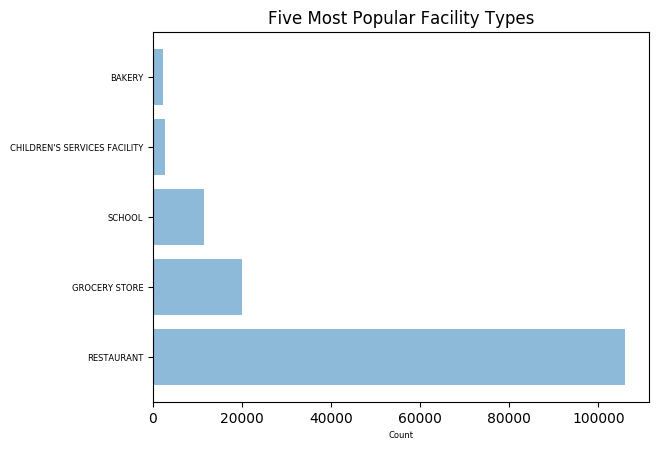

In [914]:
vc = df['facility_type'].str.upper().value_counts()[:5]


import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontsize=6)
plt.xlabel('Count', fontsize=6)
plt.title('Five Most Popular Facility Types')

plt.show()

In [915]:
df['risk'].value_counts()

Risk 1 (High)      116738
Risk 2 (Medium)     29228
Risk 3 (Low)         9033
Not Disclosed           2
Name: risk, dtype: int64

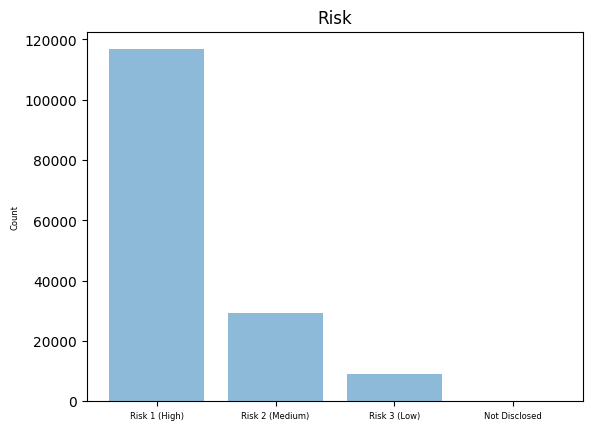

In [923]:
vc = df['risk'].value_counts()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Risk')

plt.show()

In [777]:
#sample restaurant
df[df['facility_type']=='Restaurant'].sample(n=1, random_state=777)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
159567,1096600,THREE HAPPINESS RESTAURANT,THREE HAPPINESS RESTAURANT,39807,Restaurant,Risk 1 (High),209 W CERMAK RD,CHICAGO,IL,60616,2012-10-25T00:00:00.000,Complaint,Fail,"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: FOUND FRUIT FLY ACTIVITY AT BASEMENT STORAGE AREAS ON WALLS AND CEILING. OBSERVED ABOUT 50 FRUIT FLIES. CITATION ISSUED. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: FOUND WOK STATIONS NOT CLEAN AT MAIN KITCHEN.(EXCESSIVE GREASE BUILDUP) | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FOUND FLOORS NOT CLEAN AT BASEMENT/MAIN KITCHEN PREPARATION AREAS. | 41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED - Comments: FOUND CLUTTER AT BASEMENT STORAGE AREAS. (BOXES, TOOLS, PERSONAL ITEMS,ETC.)",Not Disclosed,Not Disclosed,Not Disclosed,10/25/12


Cities

In [919]:
df['city'].value_counts()[:10]

CHICAGO              154873
NOT DISCLOSED            50
SCHAUMBURG               15
ELK GROVE VILLAGE         8
EVANSTON                  7
SKOKIE                    4
ELMHURST                  4
MAYWOOD                   4
NILES NILES               4
OAK PARK                  3
Name: city, dtype: int64

In [872]:
len(df['city'].unique())

29

Results

In [920]:
df['results'].value_counts()

Pass                  85754
Fail                  37804
Pass w/ Conditions    31443
Name: results, dtype: int64

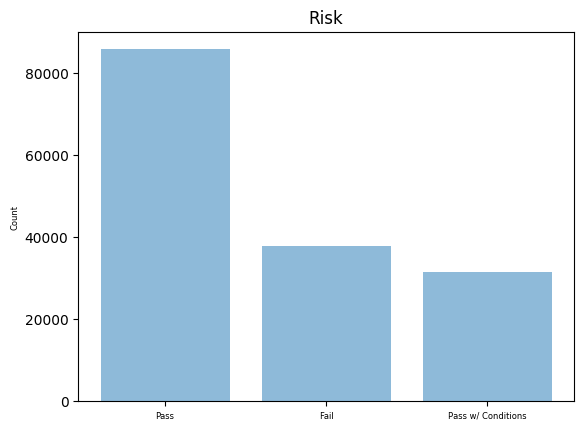

In [924]:
vc = df['results'].value_counts()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Risk')

plt.show()

In [926]:
df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', 'inspection_date_new'],
      dtype='object')

In [927]:
#Drop Unneccesary Columns
select_cols = ['results', 'violations']

#Create prediction dataframe for the prediction modeling
pred_df = df.copy()
pred_df = pred_df[select_cols]


In [928]:
pred_df.head(2)

,results,violations
0,Fail,"22. PROPER COLD HOLDING TEMPERATURES - Comments: TCS FOODS AT IMPROPER COLD HOLDING TEMPERATURES IN WALK IN COOLER: ROAST BEEF 47.0F, HAM 47.1F, COOKED CHICKEN 47.4F, COLESLAW 47.4F, SOUP 47.2F. ALL FOOD DISCARDED AND DENATURED AT THIS TIME. APPROX 50LBS $200 VALUE. CITATION ISSUED PRIORITY VIOLATION 7-38-005(A). | 33. PROPER COOLING METHODS USED; ADEQUATE EQUIPMENT FOR TEMPERATURE CONTROL - Comments: WALK IN COOLER IN POOR REPAIR, IMPROPER AMBIENT TEMPERATURE OF 48.0F. INSTD TO REPAIR AND HAVE ABLE TO MAINTAIN PRODUCT TEMPERATURE OF 41F OR BELOW AT ALL TIMES. PRIORITY VIOLATION 7-38-005. CITATION ISSUED | 50. HOT & COLD WATER AVAILABLE; ADEQUATE PRESSURE - Comments: NO HOT RUNNING WATER UNDER CITY PRESSURE THROUGH OUT FACILITY, 60F-62F. INSTD TO MAINTAIN HOT RUNNING WATER UNDER CITY PRESSURE AT ALL TIMES (100F AT HANDWASH SINKS, 110F AT 3-COMPARTMENT SINK). CITATION ISSUED 7-38-030(C)"
1,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: NO EMPLOYEE HEALTH POLICY ON SITE. MUST PROVIDE WRITTEN EMPLOYEE ACKNOWLEDGED POLICY FOR ALL EMPLOYEES. PRIORITY FOUNDATION VIOLATION. 7-38-010 CITATION ISSUED | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO VOMIT AND DIARRHEA CLEAN UP POLICY ON SITE. MUST PROVIDE PROCEDURE FOR THE CLEAN UP OF VOMIT AND DIARRHEAL EVENTS. MUST PROVIDE CORRESPONDING EQUIPMENT OUTLINED IN THE PROCEDURE. PRIORITY FOUNDATION VIOLATION. PRIORITY FOUNDATION 7-38-005 CITATION ISSUED | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: UNCLEAN KNIVES IN KNIFE RACK. INSTD TO CLEAN KNIVES AND STORE ONLY CLEAN KNIVES IN KNIFE RACK | 57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING - Comments: EMPLOYEE MISSING FOOD HANDLER TRAINING. INSTD TO OBTAIN TRAINING AND MAINTAIN VERIFICATION ON SITE"


In [929]:
print(pred_df.info())
print(pred_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155001 entries, 0 to 212021
Data columns (total 2 columns):
results       155001 non-null object
violations    155001 non-null object
dtypes: object(2)
memory usage: 3.5+ MB
None
       results  \
count   155001   
unique       3   
top       Pass   
freq     85754   

                                                                                                                               violations  
count                                                                                                                              155001  
unique                                                                                                                             153907  
top     45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING. MUST PROVIDE.  
freq                                                                                                                    

Location

<a id='engineering'></a>
## 2. Feature Engineering

Notice, the format of the violations column. The column includes the code violation number, the code description, and the inspector's comments on the specific violation. 

Sample:

"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: POOLING WATER THROUGHOUT REAR LARGE BAR. MUST MAINTAIN DRY. MISSING FLOOR TILES AND UNEVEN FLOORING THROUGHOUT DISH AREA WITH POOLING WATER. MUST MAKE FLOORS SMOOTH AND EASILY CLEANABLE.   | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: MUST INSTALL CEILINGS IN THE NEWLY INSTALL FRONT WASHROOMS. RAW WOODEN WALL COVERING IN MENS WASHROOM. MUST PROPERLY SEAL."


* Extract only comments from violations, drop rest of text


* map Results_Flag
The results currently fall into one of three buckets. I want to map these categorical columns to specific flag values.

In [933]:
#Check sample Violation entry
pred_df['violations'].sample(n=1, random_state=512)

154241    34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: POOLING WATER THROUGHOUT REAR LARGE BAR. MUST MAINTAIN DRY. MISSING FLOOR TILES AND UNEVEN FLOORING THROUGHOUT DISH AREA WITH POOLING WATER. MUST MAKE FLOORS SMOOTH AND EASILY CLEANABLE.   | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: MUST INSTALL CEILINGS IN THE NEWLY INSTALL FRONT WASHROOMS. RAW WOODEN WALL COVERING IN MENS WASHROOM. MUST PROPERLY SEAL.   | 37. TOILET ROOM DOORS SELF CLOSING: DRESSING ROOMS WITH LOCKERS PROVIDED: COMPLETE SEPARATION FROM LIVING/SLEEPING QUARTERS - Comments: MUST PROVIDE SELF-CLOSING DEVICES ON NEWLY INSTALL WASHROOMS IN THE FRONT DINING/BAR AREA.   | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: MUST INSTALL AN EXPOSED HAND SINK IN NEWLY REMODELED/INSTALLED FRONT BAR.
Name: violat

In [934]:
#regex expression to extract the text following "Comments:"
pred_df.violations = pred_df.violations.str.findall(r"(?:\sComments:\s.*?)?(?:[|]|$)")

In [935]:
#Now check the same sample
pred_df['violations'].sample(n=1, random_state=512)

154241    [ Comments: POOLING WATER THROUGHOUT REAR LARGE BAR. MUST MAINTAIN DRY. MISSING FLOOR TILES AND UNEVEN FLOORING THROUGHOUT DISH AREA WITH POOLING WATER. MUST MAKE FLOORS SMOOTH AND EASILY CLEANABLE.   |,  Comments: MUST INSTALL CEILINGS IN THE NEWLY INSTALL FRONT WASHROOMS. RAW WOODEN WALL COVERING IN MENS WASHROOM. MUST PROPERLY SEAL.   |,  Comments: MUST PROVIDE SELF-CLOSING DEVICES ON NEWLY INSTALL WASHROOMS IN THE FRONT DINING/BAR AREA.   |,  Comments: MUST INSTALL AN EXPOSED HAND SINK IN NEWLY REMODELED/INSTALLED FRONT BAR., ]
Name: violations, dtype: object

Notice, each observation is now a list of the inspector's comments. 

In [936]:
#Lemmatize Violations
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

pred_df.violations = pred_df.violations.str.join(' ')

#remove "Comments"
pred_df['violations'] = pred_df['violations'].str.replace('Comments*\s','')
pred_df['violations'] = pred_df['violations'].str.replace('Comments','')

#Remove Punctuation
pred_df['violations'] = pred_df['violations'].str.replace('[^\w\s]','')

#Remove non-alphanumeric
pred_df['violations'] = pred_df['violations'].str.replace('[^\D\s]','')


In [937]:
#Now check sample violation
pred_df['violations'].sample(n=1, random_state=512)

154241      POOLING WATER THROUGHOUT REAR LARGE BAR MUST MAINTAIN DRY MISSING FLOOR TILES AND UNEVEN FLOORING THROUGHOUT DISH AREA WITH POOLING WATER MUST MAKE FLOORS SMOOTH AND EASILY CLEANABLE      MUST INSTALL CEILINGS IN THE NEWLY INSTALL FRONT WASHROOMS RAW WOODEN WALL COVERING IN MENS WASHROOM MUST PROPERLY SEAL      MUST PROVIDE SELFCLOSING DEVICES ON NEWLY INSTALL WASHROOMS IN THE FRONT DININGBAR AREA      MUST INSTALL AN EXPOSED HAND SINK IN NEWLY REMODELEDINSTALLED FRONT BAR 
Name: violations, dtype: object

Now, we need to conver the results column into a categorical flag

In [938]:
pred_df['results'].value_counts()

Pass                  85754
Fail                  37804
Pass w/ Conditions    31443
Name: results, dtype: int64

In [942]:
# convert label to a binary numerical variable
pred_df['results_flag'] = pred_df.results.map({'Pass':0,
                                     'Fail':1,
                                     'Pass w/ Conditions':2,
                                     'No Entry':3,
                                     'Not Ready':4,
                                     'Out of Business':5 })

In [948]:
pred_df.sample(n=5, random_state=312)

,results,violations,results_flag
3238,Pass,OBSERVED TORN DOOR GASKET INSIDE OF THE ONE DOOR COOLER WHERE THE EGGS AND CHEESE IS STORED INSTRUCTED TO REPLACE AND MAINTAIN OBSERVED STAINED CEILING TILES ABOVE THE ONE DOOR COOLER AND IN THE REAR NEAR THE UNUSED GROCERYDELI SIDE INSTRUCTED TO REPLACE THE STAINED CEILING TILES OBSERVED EXCESS CLUTTER AND UNNECESSARYUNUSED ARTICLES STORED IN THE REAR NEAR THE UNUSED DELI AREA AND BASEMENT MUST REMOVE ALL UNNECESSARYUNUSED ARTICLES CLEAN ALL CLUTTER ORGANIZE AND MAINTAIN AREAS AT ALL TIMES OBSERVED A MISSING LIGHT SHIELD IN THE EMPLOYEE TOLIET ROOM CEILING LIGHT INSTRUCTED TO PROVIDE AND MAINTAIN AT ALL TIMES,0
90223,Pass w/ Conditions,PREVIOUS MINOR VIOLATION FROM REPORT JULY NOT ORRECTED OBSERVED NO FOOD HANDLER CERTIFICATES ON PREMISES AT THIS TIME INSTRUCTED TO PROVIDE GIVEN COPY OF IDPHS FOOD HANDLER INFO AT THIS TIME INSTRUCTED MANAGER TO PROVIDE CERTIFICATES AT ALL TIMES SERIOUS VIOLATION NEW CUTTING BOARD NEEDED AT FRONT PREP LINE MUST INSTALL AND MAINTAIN ALL CONTACT SURFACES IN NEED OF CLEANING HANDLES TO COOLERS HANDS SINK FAUCET KNOBS AIR VENTS IN WALK IN COOLER IN NEED OF CLEANING INTERIOR OF ICE MACHINE IN NEED OF CLEANING TO REMOVE BUILD UP MUST CLEAN AND MAINTAIN AT ALL TIMES FLOOR DRAINS IN NEED OF DETAIL CLEANING TO REMOVE ALL BUILD UP MUST DETAIL CLEAN AND MAINTAIN AT ALL TIMES LIGHT SHIELD IN REAR PREP AREA IN NEED OF REPLACING OR REPAIR MUST CORRECT AND MAINTAIN,2
131791,Pass w/ Conditions,FOUD BAGS OF GARDEN SALADS STORED INSIDE THE DISPLAY COOLER INTERNAL TEMPERATURE TAKEN OF FOOD PRODUCTS READS FTHE FOOD PRODUCTS WHERE DISCARDED AND DENATURED THE TOTAL COST AND THE TOTAL WEIGHT LBS CRITICAL VIOLATION A THE CUTTING BOARDS IN THE MEAT CUTTING AREAHAS OPEN SEAMSMUST REPLACE EQUIPMENT MUST CLEAN AND SANITIZE THE MEAT SLICER IN THE DELI SECTIONHAS OLD FOOD PARTICALS ON EQUIPMENT AND DETAIL CLEAN THE RUNNERS OF DOOR AT THE DELI COUNTER HAS OLD FOOD DEBRISINSTRUCTED TO DETAIL CLEAN ALL EQUIPMENT ALSO LIGHT SHIELD COVERS NEED CLEANING OF DUST IN THE REAR MEAT CUTTING SECTION WATER LEAKING FROM CEILING NEAR THE PACKAGE MEAT COUNTERTHE ABOVE HAS A PAN ON FLOOR TO CATCH WATERINSTRUCTED TO REPAIR LEAK,2
171701,Pass w/ Conditions,FACILITY NOT MAINTAINING PROPER TEMPERATURE FOUND TWO DOORS PREP REACH IN COOLER AT F INADEQUATE FOOD PROTECTION INSTRUCTED MUST REPAIR COOLER AND KEEP AT F OR BELOW TAG HELD FOR INSPECTION PLACED ON UNIT WHEN REPAIRED TO FAX LETTER REQUESTING TAG REMOVAL CITATION ISSUED A CRITICAL POTENTIALLY HAZARDOUS FOODS INSIDE ABOVE COOLER AT IMPROPER TEMPERATURES ABOUT LBS COOKED PORK F LBS VEGETABLES AND CHICKEN SOUP F LBS STUFFED PEPPERS F LBS RICE F LBS COOKED CHICKEN F AND LBS BEANS AT F INADEQUATE FOOD PROTECTION INSTRUCTED COLD POTENTIALLY HAZARDOUS FOODS MUST BE AT F OR BELOW FOOD DISCARDED V CRITICAL CITATION ISSUED A OBSERVED NO SANITARY HAND DRYING DEVICES AT EXPOSED SINK OR FOR HAND WAHING BOWL IN WASHROOM MUST PROVIDE PAPER TOWELS HAND DRYING DEVICES FOR SINKS AT ALL TIMES CRITICAL CITATION ISSUED NO CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIALLY HAZARDOUS FOODS ARE PREPARED AND SERVED PREMISES HAS A CITY CERTIFICATE FOR FABIOLA PAREDES BUT PERSON NOT ON D...,2
41464,Pass,MUST REPAIR DETACHED CAULKING AROUND HAND SINK IN CHILDREN TOILET ROOM,0


<a id='model'></a>
# 3. Model

<a id='modeloverview'> </a>
## 3.1 Model Overview


### 3.1 Set X & y Variables

In [950]:
X = pred_df.violations
y = pred_df.results_flag
print(X.shape)
print(y.shape)

(155001,)
(155001,)


### 3.2 Train/Test Split

In [951]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(124000,)
(31001,)
(124000,)
(31001,)


### 3.3 Vectorize The Text

In [952]:
# instantiate the vectorizer
vect = CountVectorizer()

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<124000x90333 sparse matrix of type '<class 'numpy.int64'>'
	with 8390365 stored elements in Compressed Sparse Row format>

In [953]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<31001x90333 sparse matrix of type '<class 'numpy.int64'>'
	with 2081473 stored elements in Compressed Sparse Row format>

In [954]:
countvectorizer_matrix = vect.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

,___lbs,__through,_a,aa,aab,aaccumuation,aade,aafound,aal,aall,...,zucchini,zucchinibaby,zucchinin,zuccini,zuchinisasparagus,zumba,zumex,zurich,ºc,ºf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='model'> </a>
## 5. Build Baseline Models
* Naive Bayes Model, "Model 1"
* Logistic Regression, "Model 2"
* Support Vector Machine, "Model 3"

### a) Naive Bayes Model

In [955]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [956]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 75.5 ms, sys: 113 ms, total: 189 ms
Wall time: 252 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [957]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [958]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.8232315086610109


In [959]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     17151
           1       0.74      0.71      0.73      7561
           2       0.65      0.77      0.71      6289

    accuracy                           0.82     31001
   macro avg       0.78      0.79      0.78     31001
weighted avg       0.83      0.82      0.83     31001



In [960]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[15269   774  1108]
 [  669  5398  1494]
 [  300  1135  4854]]


### b) Logistic Regression

In [961]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [962]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 34min 35s, sys: 5min 10s, total: 39min 45s
Wall time: 6min 56s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [963]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
y_pred_class_train = logreg.predict(X_train_dtm)

In [964]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9241959936776233


In [965]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17151
           1       0.88      0.85      0.86      7561
           2       0.87      0.84      0.85      6289

    accuracy                           0.92     31001
   macro avg       0.90      0.89      0.90     31001
weighted avg       0.92      0.92      0.92     31001

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     68603
           1       0.96      0.93      0.95     30243
           2       0.95      0.94      0.95     25154

    accuracy                           0.97    124000
   macro avg       0.96      0.96      0.96    124000
weighted avg       0.97      0.97      0.97    124000



In [966]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16954   117    80]
 [  423  6408   730]
 [  235   765  5289]]


### c) Support Vector Machine

In [967]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [968]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

CPU times: user 10.3 s, sys: 155 ms, total: 10.4 s
Wall time: 9.59 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [969]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [970]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9137447179123254


In [971]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     17151
           1       0.91      0.78      0.84      7561
           2       0.81      0.89      0.85      6289

    accuracy                           0.91     31001
   macro avg       0.89      0.88      0.89     31001
weighted avg       0.91      0.91      0.91     31001



In [972]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16876   116   159]
 [  553  5880  1128]
 [  262   456  5571]]


### 6. Improve Model Performance (for best performing model)
* Remove stopwords
* Include n-grams
* Limit min & max document frequencies



In [43]:
#default parameters for countvectorizer model
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [976]:
print(len(pred_df)*0.05)
print(len(pred_df)*0.2)

7750.05
31000.2


In [977]:
# remove English stop words
vect_optimized = CountVectorizer(stop_words='english',
                                 lowercase=True,
                                 ngram_range=(1,4), 
                                 min_df=0.05, 
                                 max_df=0.4)



In [978]:
countvectorizer_matrix = vect_optimized.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect_optimized.get_feature_names())
countvectorizer_matrix_df

,accordance,accumulation,adequate,adequately,air,allergen,area clean,area instructed,areas,articles,...,wall,walls,walls ceilings,walls ceilings shall,walls ceilings shall good,wash,washing,washroom,water,working
0,0,0,0,0,1,0,0,0,0,0,...,1,3,1,1,1,2,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,7,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
123996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123998,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1


In [979]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect_optimized.fit_transform(X_train)
X_test_dtm = vect_optimized.transform(X_test)


In [980]:
#Logistitc Regression
model = LogisticRegression(max_iter=500)
%time model.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

CPU times: user 27.4 s, sys: 187 ms, total: 27.6 s
Wall time: 27.7 s
0.896551724137931


/Users/stephenstark/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [981]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     17151
           1       0.85      0.77      0.81      7561
           2       0.83      0.81      0.82      6289

    accuracy                           0.90     31001
   macro avg       0.87      0.85      0.86     31001
weighted avg       0.89      0.90      0.89     31001



In [982]:
#Check for over fitting
y_pred_class_train = model.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     68603
           1       0.85      0.76      0.80     30243
           2       0.82      0.81      0.82     25154

    accuracy                           0.90    124000
   macro avg       0.87      0.85      0.86    124000
weighted avg       0.89      0.90      0.89    124000



Text(95.72222222222221, 0.5, 'Actual')

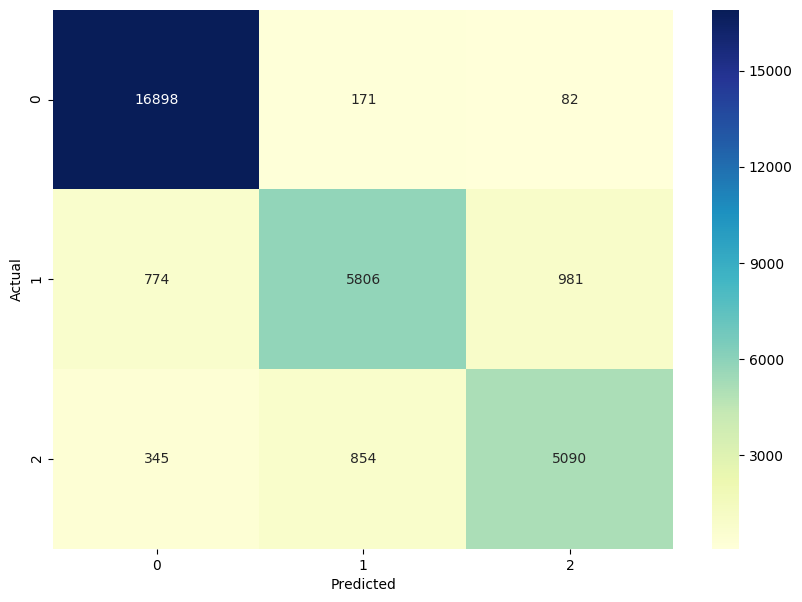

In [983]:
cnf_matrix_test = confusion_matrix (y_test, y_pred_class)

import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix_test, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### 7. Troubleshoot

In [984]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [985]:
y_pred_prob = model.predict_proba(X_test_dtm)
y_pred_class = model.predict(X_test_dtm)

In [986]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [987]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [988]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

(2244, 6)

In [989]:
pd.set_option('display.max_colwidth', 1000)

In [990]:
results_review_df.head(10)

,violations,results_flag,predicted,0-prob,1-prob,2-prob
2,WALK IN COOLER IN REAR NOT OPERABLECONNECTED AT THIS TIMEMUST HAVE COOLER CONNECTEDMAINTAINING F OR BELOW CRITICAL VIOLATION A NO EXPOSED HAND SINK IN REAR PREPDISH WASING AREAMUST INSTALL TO CITY PLUMBING WITH HOTCOLD WATER AND HAND DRYING DEVICE CRITICAL VIOLATION OBSERVED HOT FOOD ARE NOT PROTECTED FROM PUBLICMUST INTALL BARRIER AT COOLERS AND FRONT ENTRANCE AREA SERIOUS VIOLATION A NO CITY OF CHICAGO FOOD SANITATION CERTIFICATE PROVIDED FOR MANAGER AT THIS TIMEMUST PROVIDE SERIOUS VIOLATION NO WATER AT HAND SINKINADEQUATE HAND WASHING FACILITIESND WASHROOM NOT ACCESSIBLE FOR INSPECTION ATTHIS TIMEMUST PROVIDE AT NEXT INSPECTION THE FOLLOWING NOT CLEAN OF DEBRISOR PAINTETCINTERIOR EXTERIOR OF ICE MACHINECOMP SINKDINING ROOM TABLES WALK IN COOLERSPREP TABLESSINKINSTRUCTED TO CLEANMAINTAIN DEBRIS ON FLOORS IN MOP ROOM AND BEHIND COOKING EQUIPMENTMUST CLEANMAINTAIN OPENINGSGAPS ALONG WALLCEILING AREASMUST SEALREPAIR TO PREVENT HIDING AREAS FOR INSECTS ...,1,1,2.045684e-09,0.561452,0.438548
7,OBSERVED NO EXPOSED HAND SINK IN THE BASEMENT PREP AREA MUST INSTALL HAND SINK WITH HOT COLD RUNNING WATER SOAP AND PAPER TOWELS CRITICAL VIOLATION MUST INSTALL SPLASH GUARD BETWEEN THE HAND SINK AND COMP PREP SINK IN ST FLOOR PREP AREA AND SEAL OR PAINT RAW WOOD SERVICE COUNTER IN SAID AREA MUST REPAIR CRACKED FLOOR TILES IN DINING AREA SURFACE MUST BE SMOOTH AND EASILY CLEANABLE ALSO CLEAN DEBRIS FROM FLOOR THROUGHOUT BASEMENT AND FURNACE CLOSET MUST REPAIR HOLE IN WALL UNDER STORAGE RACKS NEAR OFFICESTORAGE ROOM IN BASEMENT ALSO REPAIR PEELING PAINT FROM CEILING IN BASEMENT SURFACE MUST BE SMOOTH AND EASILY CLEANABLE MUST INSTALL SELFCLOSING DEVICE ON EMPLOYEE TOILET ROOM IN BASEMENT MUST PROVIDE HOOKS FOR WET MOPS BROOM STORAGE,1,1,1.570072e-02,0.520521,0.463779
21,found outside garbage area unclean with overflowing garbage and open lids Serious violation citation issued found no self closing door in restroom Found leaky drainage pipe at handsink,1,1,5.477929e-02,0.503633,0.441588
22,Food ice for consumption not protected during storage Upper interior of icesoda dispensing machine with large amount of black slimy mold like substance in ice tray and area along left side interior Must detail clean machine and sanitize Serious violation a Found door on west side of restaurant with gap along bottom edge All doors must be tight fitting to prevent pest entry Must repair Serious violation,1,0,5.065729e-01,0.309175,0.184252
63,SEAL SMALL OPENING ALONG THE TOP OF THE REAR EXIT DOOR LEADING TO THE OUTSIDE MUST DETAIL CLEAN AND SANITIZE ALL CUBBIE HOLES AND TOYS MUST CLEAN INTEIOR OF KITCHEN CABINETSREFRIGERATION UNITSTOVEWINDOW SILLS THROUGHOUT ALL CLASSROOMSWALLS AND ALL DUSTY AND DIRTY SURFACES MUST DETAIL CLEAN FLOORS BEHIND STOVE AND REFRIGERATION UNIT IN KITCHENBEHIND CUBBIE HOLES IN CLASSROOM AND CLEAN ALL DIRTY AREA RUGS MUST REMOVE DUST BUILD UP FROM VENTILATION FANS IN ALL WASHROOMS MUST ALSO REPAIR ST VENTILATION FAN IN MIDDLE WASHROOM MUST REMOVE ALL CLUTTER FROM OUTSIDE STORAGE AREAFROM REAR OF WEST CLASSROOM AND THROUGHOUT WHERE NEEDED,0,0,5.776002e-01,0.360176,0.062224
82,Observed a black moldlike substance on the interior portions of the ice machine Instructed facility to clean sanitize and maintain Serious citation issued a,1,2,1.909773e-01,0.341600,0.467423
97,All cold food shall be stored at a temperature of F or less FOUND POTENTIALLY HAZARDOUS FOODS AT IMPROPER TEMPERATURECRITICAL VIOLATIONCITATION ISSUEDCHOCO MILK AT F PCS OF PINT EACH MILK F PCS OF PINT LBS LIQUID EGGS AT FMANAGER DISCARDED THE FOODINSTRUCTED COLD FOOD MUST BE F OR BELOW The floors shall be constructed per code be smooth and easily cleaned and be kept clean and in good repair FLOOR AT THE REAR AREA BELOW SODA CONNECTION UNCLEANMUST CLEAN AND MAINTAINFLOOR INSIDE WALK IN COOLER AND WALK IN FREEZER BASEMENT UNCLEANMUST CLEAN AND MAINTAIN The walls and ceilings shall be in good repair and easily cleaned

# Summary
I decided to perform a multi-class classification analysis.  I narrowed my dataset to pass, fail, or pass w/ conditions due to the sufficiency of data. It appears the logistic regression had the best performance of the three models I demonstrated above. The original logisitc regression actually performed better than the one I attempted to optimize. It had a test accuracy of 92%.  The model showed slight signs of overfitting as train accuracy was 96%. Precision and recall for test were 92% for each. Precision was 96% for class 0 (pass), 87% for class 1 (fail) and 86% for class 2 (pass w/ conditions). Furthermore we know f-1 scores are the weighted averaged of precision and recall. F1 scores of 98%, 86%, and 85%, for the same classes listed previously. The model clearly is able to accuractely identify pass recommendations but struggles a little more with fail and pass with conditions, which makes sense intuitively. the F1 scores show slightly more signs of overfitting so I would attempt to adjust that in my parameter tuning. This is out of scope for this analysis, but perhaps I would do some sort of grid search or random search to approximate better parameter values.
* **Pre-processing** For text pre-processing, I decided that we needed to remove stopwords for this analysis. They are noise and do not contribute to the signal of the prediction. I also removed all the digits as again I believe they were more of a distraction. Also, within CountVectorizer, I included parameters to lowercase all words an
* **Train/Test Split** I noticed a considerable class imbalance in the dataset between the three values. I made sure to stratify my sampling in train test split to ensure the train samples and test samples resembled the population of the dataset. Another thing I considered doing but did not as it was out of scope for this analysis was training my model on an equal split data using an under-sampling or oversampling approach. This would give the model a fair chance to fully train each class equally as opposed to seeing more data of the dominate class.


<a id='end'> </a>

# Scratch

In [58]:
df_clean[df_clean['Inspection ID']==2313093]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
35711,2313093,The Indian Garden Restaurant,The Indian Garden Restaurant,1646652.0,Restaurant,Risk 1 (High),247 E ONTARIO ST,CHICAGO,IL,60611.0,09/30/2019,Canvass,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: FOUND 5 LIVE COCKROACHES BEHIND FOOD STORAGE SHELVES AND MOP CLOSET, INSTRUCTED TO ELIMINATE INSECTS ACTIVITY IN ALL AFFECTED AREAS, PEST CONTROL SERVICE RECOMMENDED. PRIORITY FOUNDATION VIOLATION 7-38-020(A) | 43. IN-USE UTENSILS: PROPERLY STORED - Comments: KNIVES WEDGED BETWEEN 3-COMP SINK AND TABLE, INSTRUCTED TO KEEP IN A CLEAN SURFACE. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: CRACKS AND CREVICES NOTED THROUGH OUT KITCHEN AND DRY STORAGE ROOM. INSTRUCTED TO SEAL.",41.893272,-87.621469,"(-87.62146879561675, 41.8932723034826)"
